# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [42]:
import math

def jarvismarch(inputSet):
    '''
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''
    # Find the most left point 
    # Extend the line in clockwse

    #ADD YOUR CODE HERE
    bottom_most_point = min(inputSet, key = lambda p: (p[1], p[0]))
    return outputSet

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [43]:
def grahamscan(inputSet):
    '''
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''

    #ADD YOUR CODE HERE

    return outputSet

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [44]:
'''
FOR TESTING PURPOSE ONLY!!! DELETE WHEN UPLOAD
'''
def orientation(p, q, r):
    """
    Determines the orientation of three points (p, q, r).
    Returns:
        0 if collinear
        1 if clockwise
        2 if counterclockwise
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def convex_hull(points):
    n = len(points)
    if n < 3:
        return points

    hull = []
    l = 0  # Index of leftmost point
    for i in range(1, n):
        if points[i][0] < points[l][0]:
            l = i

    p = l
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i
        p = q
        if p == l:
            break

    return hull

# Example usage
points = [(0, 3), (2, 2), (1, 1), (2, 1), (3, 0), (0, 0), (3, 3)]

[(0, 3), (0, 0), (3, 0), (3, 3)]


In [45]:
'''
TESTING PURPOSE ONLY !!!!!!!!
'''
import random as rd
def generte_random_points():
    points = []
    number_of_points = rd.randint(100,1000)
    for i in range(number_of_points):
        x = rd.randint(-100,100)
        y = rd.randint(-100,100)
        points.append((x,y))
    return points


2 [[(55, -15), (42, 100)], [(-9, 75), (77, 63)], [(-77, -13), (-34, 86)], [(64, -61), (13, -72)], [(-84, -75), (73, 47)], [(-54, -54), (55, -77)], [(-83, 45), (82, 83)], [(-8, 19), (91, -79)], [(-52, -35), (92, -1)], [(-52, -68), (59, -4)], [(2, -43), (62, 87)], [(-87, -4), (-90, -72)], [(-80, 89), (-32, -28)], [(95, -10), (-53, 17)], [(40, -20), (77, -5)], [(-29, -78), (-47, 90)], [(56, -6), (-80, -72)], [(-53, -77), (-19, 10)], [(78, -9), (8, 10)], [(-25, -39), (-59, 100)], [(32, 55), (-57, -30)], [(12, 67), (-25, -8)], [(-19, -19), (48, -85)], [(26, 13), (-97, 76)], [(-93, -48), (80, -83)], [(-44, -72), (68, 26)], [(41, 92), (-36, 34)], [(-22, 55), (-74, -3)], [(90, -9), (-62, 69)], [(81, 78), (-13, 11)], [(36, 27), (-87, 6)], [(-9, 31), (2, 67)], [(24, -58), (99, -39)], [(11, 64), (-12, -74)], [(-43, -82), (44, -30)], [(-16, 38), (39, 83)], [(46, -71), (-93, 14)], [(-69, -40), (1, -23)], [(-4, -14), (-23, -74)], [(6, 26), (32, 29)], [(-89, 90), (86, 47)], [(97, 36), (49, 76)], [(0,

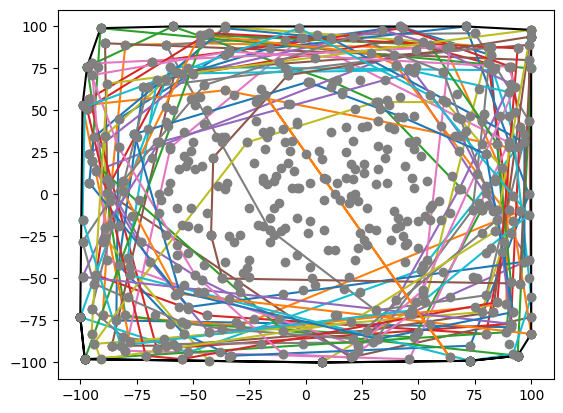

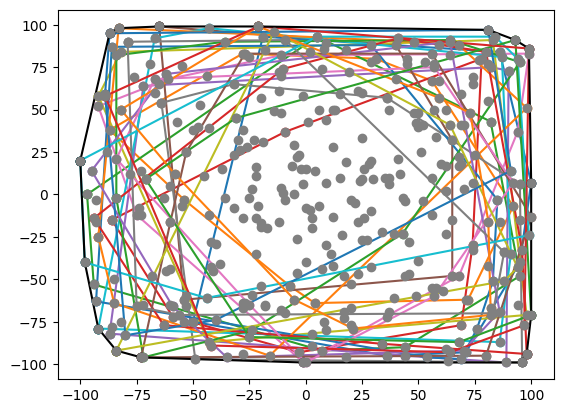

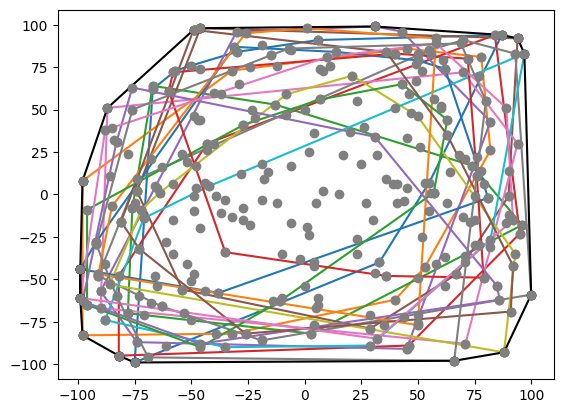

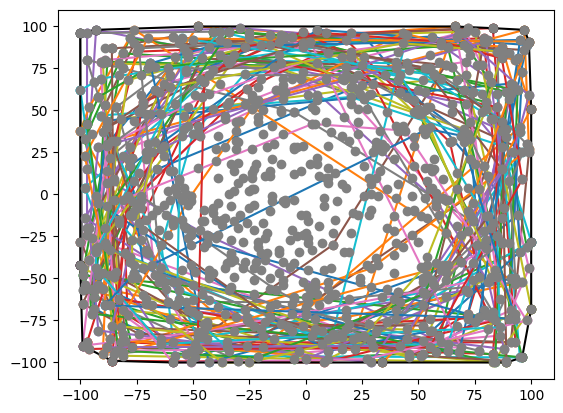

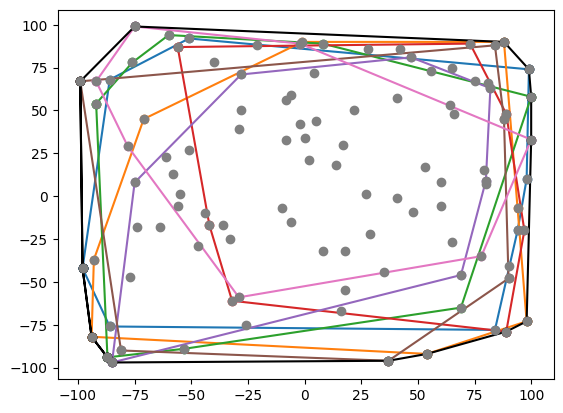

<Figure size 640x480 with 0 Axes>

In [75]:

import matplotlib.pyplot as plt

def chen(inputSet):
    '''
    Returns the list of points that lie on the convex hull (chen's algorithm)
            Parameters:
                    inputSet (list): a list of 2D points

            Returns:
                    outputSet (list): a list of 2D points
    '''
    #ADD YOUR CODE HERE
    '''
    Steps:
    1. Divide into sections, starting from 3
    2  Apply Jarvis march to each section -> filter sections
    3. Run jarvis march on each section
    ''' 
    def same_point(a,b):
        return a[0] == b[0] and a[1] == b[1]

    # divide the set into sections based on h
    def divide_sections(points, point_in_sec):
        sections = []
        new_section = []
        ite = 0
        
        for point in points:
            if ite == point_in_sec:
                sections.append(new_section.copy())
                new_section = []
                ite = 0
            
            new_section.append(point)
            ite += 1
        
        sections.append(new_section)
        return sections
    
    # Calculate the angle from current point to last point and checkpoint
    def angle(last_point, current_point, check_point):
        dot_product = (last_point[0] - current_point[0]) * (check_point[0] - current_point[0]) \
            + (last_point[1] - current_point[1]) * (check_point[1] - current_point[1])
        
        length_product = math.sqrt((last_point[0] - current_point[0])**2 + (last_point[1] - current_point[1]) ** 2) * \
            math.sqrt((check_point[0] - current_point[0]) ** 2 + (check_point[1] - current_point[1]) ** 2)
        
        cos_theta = dot_product / length_product
        cos_theta = max(min(cos_theta, 1.0), -1.0)  # clamp to [-1, 1] to avoid domain error
        
        return math.acos(cos_theta)
    
    def distance(a,b):
        return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2
        
    # Search the tangend to each section from the current point
    def linear_search(last_point, point, section):
        max_angle = 0
        max_angle_point = last_point
        for conv_point in section:
            if same_point(conv_point, point):
                # skip if it's the point itself
                continue
            conv_point_angle = angle(last_point, point, conv_point)
            if  conv_point_angle > max_angle:
                max_angle = conv_point_angle
                max_angle_point = conv_point
            elif conv_point_angle == max_angle:
                if distance(conv_point, point) > distance(max_angle_point, point):
                   max_angle = conv_point_angle
                   max_angle_point = conv_point 
        return max_angle,max_angle_point
    
    # Find the next
    def find_next_global_convex_hull(recorded_ch, divided_sections):
        current_point = recorded_ch[-1]
        last_point = recorded_ch[-2]
        most_right_angle = 0
        most_right_point = [last_point]
        
        for section in divided_sections:
            section_tangent_angle, section_tangent_point = linear_search(last_point, current_point, section)
            if section_tangent_angle > most_right_angle:
                most_right_angle = section_tangent_angle
                most_right_point = section_tangent_point
            
            elif section_tangent_angle == most_right_angle:
                if distance(current_point, section_tangent_point) > distance(current_point, most_right_point):
                    most_right_angle = section_tangent_angle
                    most_right_point = section_tangent_point 

        return most_right_point
    
        
    init_h = 2
    left_most_point = min(inputSet, key=lambda point: point[0])
    # This will be the point one unit above the startpoint, to support it finds the next convex hull
    # It will be recorded in the convexhull list with idx 0
    origin_point = (left_most_point[0],left_most_point[1] + 1)
    
    # check the time of loops is within the limit 
    in_h_times = False
    while not in_h_times:
        divided_section = divide_sections(inputSet, init_h)
        for sections in divided_section:
            # Find Local Convex Hull
            divided_section = list(map(lambda section: convex_hull(section), divided_section)) 
    
        global_convex = [origin_point, left_most_point]

        # find global convex hulls
        for i in range(init_h+1):
            global_convex.append(find_next_global_convex_hull(global_convex, divided_section))
            current_point = global_convex[-1]
            if same_point(current_point, global_convex[1]) and not len(global_convex) == 2\
                or init_h >= len(inputSet):
                in_h_times = True 

        # update limit h (and section number)             
        init_h = min(init_h ** 2, len(inputSet)) 
    
    # Extract the origin support point from the result list
    global_convex = global_convex[1:]
    
    # Visualisation of sectional convex hulls
    for sections in divided_section:
        x = [point[0] for point in sections]
        y = [point[1] for point in sections]
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y, marker='o')
        
    # Visualisation of the global convex hulls
    x = [point[0] for point in global_convex]
    y = [point[1] for point in global_convex]
    plt.plot(x, y, marker='o', color = 'black')

    # Visualisation of all points
    for point in inputSet:
        x = point[0]
        y = point[1]
        plt.plot(x,y, marker='o', linestyle = '',color = 'grey')

# Generate Points
# points = [(0.1, 0.8), (0.5, 0.2), (0.3, 0.6), (0.9, 0.4), (0.7, 0.3), (0.2, 0.5), (0.6, 0.9), (0.4, 0.1), (0.8, 0.7), (0.2, 0.3), (0.6, 0.1), (0.8, 0.5), (0.4, 0.8), (0.1, 0.7), (0.7, 0.6), (0.9, 0.3), (0.5, 0.9), (0.3, 0.4), (0.5, 0.6), (0.8, 0.2), (0.4, 0.5), (0.2, 0.9), (0.6, 0.3), (0.1, 0.4), (0.9, 0.7), (0.7, 0.8), (0.3, 0.1), (0.8, 0.4), (0.4, 0.6)]
for i in range(5):
    points = generte_random_points()
    # Display of sections
    chen(points)
    plt.figure()


Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

In [47]:
import random

class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__(self, input):
        pass


Use the cell below to implement the requested **experimental framework** API.

In [48]:
import timeit
import matplotlib

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__():
        pass

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [49]:
# ADD YOUR TEST CODE HERE 



